# Prepare Working Directory

## Mount the Drive 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Change to the Current Working Directory
Make sure you change to the directory where you placed in the drive

In [ ]:
%cd /content/drive/MyDrive/Age and Gender Prediction

In [5]:
!pip install -q opencv-contrib-python
!pip install -q --upgrade opencv-python
!pip install -q --upgrade opencv-contrib-python

     |████████████████████████████████| 60.5 MB 1.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 66.7 MB 1.5 MB/s 


In [6]:
import os
import torch
import pandas as pd
from tqdm import tqdm
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
from torchvision import datasets, transforms, models

It is adviced that you have GPU access to speed up the prediction 

In [7]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

CPU


# Load Model for Body Detection
Load the pretrained model for body detection. We use a FASTERRCNN with RESNET50 as the backbone

In [8]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

detection_model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = detection_model.roi_heads.box_predictor.cls_score.in_features
detection_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [9]:
PATH_TO_CHECKPOINT = 'pedestrian_detection/pretrained_weights/pretrained.pt'

In [10]:
detection_model.load_state_dict(torch.load(PATH_TO_CHECKPOINT, map_location=device))
detection_model = detection_model.eval()

# Load Age and Gender Prediction Module

In [11]:
from models.base_block import FeatClassifier, BaseClassifier
from models.resnet import resnet50
from collections import OrderedDict

In [12]:
PATH_TO_AGE_GENDER_PREDICTOR_CHECKPOINT = 'exp_result/PETA/PETA/img_model/ckpt_max.pth'

In [13]:
def load_custom_state_dict(model):

    loaded = torch.load(PATH_TO_AGE_GENDER_PREDICTOR_CHECKPOINT, map_location=device)

    if not torch.cuda.is_available():
      # remove `module.`
      new_state_dict = OrderedDict()
      for k, v in loaded['state_dicts'].items():
          name = k[7:] 
          new_state_dict[name] = v

      # load parameters
      model.load_state_dict(new_state_dict, strict=False)
    else:      
      model.load_state_dict(loaded['state_dicts'], strict=False)
    
    print("Load successful")
    model = model.eval()

In [14]:
backbone = resnet50()
classifier = BaseClassifier(nattr=35)
model = FeatClassifier(backbone, classifier)

if torch.cuda.is_available():
    model = torch.nn.DataParallel(model).cuda()

load_custom_state_dict(model)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Load successful


# Load the Super Resolution Model

In [15]:
import cv2
from cv2 import dnn_superres

In [16]:
sr = dnn_superres.DnnSuperResImpl_create()

path = "super_resolution/ESPCN_x3.pb"
sr.readModel(path)

sr.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
sr.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

sr.setModel("espcn", 3)

# Prediction

In [17]:
age_range = [[10, 30], [30, 45], [45, 50], [50, 70]]

In [18]:
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

valid_tsfm = T.Compose([
    T.Resize((256, 192)),
    T.ToTensor(),
    normalize
])

In [19]:
def get_pred_attributes(frame, x1, y1, x2, y2):
  img = frame[y1:y2, x1:x2]
  img = sr.upsample(img)
  img = Image.fromarray(img)
  img = valid_tsfm(img)
  valid_logits = model(img.unsqueeze(0))
  valid_probs = torch.sigmoid(valid_logits)
 
  age_pred = age_range[torch.argmax(valid_probs[0][0:-1])]
  gender_pred = "M" if valid_probs[0][-1] > 0.5 else "F"

  return gender_pred, age_pred

## Prediction for Video

### Load Video
Enter the name of the video file (with extension) that is placed inside the `videos` folder

In [20]:
from google.colab.patches import cv2_imshow

In [21]:
vid_file = input("Enter the filename: ")

Enter the filename: SharpView CCTV in Shopping Mall.mp4


In [30]:
vid_filename, extension = vid_file.split('.')

In [31]:
cap = cv2.VideoCapture(os.path.join('video', vid_file))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) 
fps = cap.get(cv2.CAP_PROP_FPS) 

assert fps != 0, 'Please enter a valid path to the video'

frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = frame_count/fps

print(f"Resolution: {width}, {height}")
print('Frames Per Second = ' + str(fps))
print('Number of Frames = ' + str(frame_count))
print('Duration (seconds) = ' + str(duration))

Resolution: 640, 480
Frames Per Second = 6.0
Number of Frames = 725
Duration (seconds) = 120.83333333333333


In [32]:
if not os.path.exists(f'prediction/{vid_filename}'):
  os.makedirs(f'prediction/{vid_filename}')
  
  if not os.path.exists(f'prediction/{vid_filename}/images/'):
    os.makedirs(f'prediction/{vid_filename}/images/')

In [33]:
pred_frame_by_frame = False # Toggle it to False if frame by frame prediction image of the video is not required
pred_video = False # Toggle it to False if the outputted video with bounding box and person id is not required

In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')

out = cv2.VideoWriter(f'prediction/{vid_filename}/{vid_filename}.{extension}', 
                                    fourcc, fps, (width, height))

df = pd.DataFrame(columns=['frame num', 'person id', 'bb_xmin', 'bb_ymin', 'bb_height', 'bb_width', 'age_min', 'age_max', 'age_actual', 'gender'])

i = 1

pbar = tqdm(total=frame_count)

while cap.isOpened():
  ret, frame = cap.read()
  pbar.update(1)
  
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

  val_tran = transforms.Compose([transforms.ToTensor()])
  im_pil = Image.fromarray(frame)
  im_pil = val_tran(im_pil)

  image = im_pil.to(device).unsqueeze(0)

  detection_model=detection_model.to(device)

  detection_model = detection_model.eval()
  output = detection_model(image)
  scores = output[0]['scores'].detach().cpu().numpy()
  num_people = len(scores[scores > 0.5])

  boxes = output[0]['boxes'].detach().cpu().numpy()
  boxes = boxes[:num_people]

  for j in range(num_people):
    x1, y1, x2, y2 = int(boxes[j][0]), int(boxes[j][1]), int(boxes[j][2]), int(boxes[j][3])
    gender_pred, age_pred = get_pred_attributes(frame, x1, y1, x2, y2)
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), thickness=5)
    cv2.putText(frame, f"ID: {j}", (x1, y1 - 10),
                      cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), thickness=2)

    width = abs(x2 - x1)
    height = abs(y2 - y1)

    exact_age = (age_pred[0] + age_pred[1])/2

    row = {'frame num' : i, 
          'person id' : j, 
          'bb_xmin': x1, 
          'bb_ymin': y1, 
          'bb_height': height, 
          'bb_width': width, 
          'age_min': age_pred[0], 
          'age_max': age_pred[1], 
          'age_actual': exact_age, 
          'gender': gender_pred}

    df = df.append(row, ignore_index = True)
    
  frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

  if pred_video:
    out.write(frame)

  if pred_frame_by_frame:
    cv2.imwrite(f'prediction/{vid_filename}/images/FRAME{i}.jpg', frame)
  # plt.imshow(frame)
  # plt.show()

  i += 1 

  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

  if i > frame_count:
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
df.to_csv(f'prediction/{vid_filename}/prediction.csv')

## Prediction For Images

In [ ]:
img_file = input("Enter the image filename: ")

Enter the image filename: 7.jpg


In [ ]:
img_filename, extension = img_file.split('.')

In [ ]:
img = cv2.imread(f"img/{img_file}")

In [ ]:
if not os.path.exists(f'prediction/{img_filename}'):
  os.makedirs(f'prediction/{img_filename}')

In [ ]:
df_img = pd.DataFrame(columns=['frame num', 'person id', 'bb_xmin', 'bb_ymin', 'bb_height', 'bb_width', 'age_min', 'age_max', 'age_actual', 'gender'])

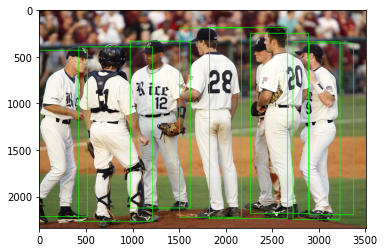

In [ ]:
frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

val_tran = transforms.Compose([transforms.ToTensor()])
im_pil = Image.fromarray(frame)
im_pil = val_tran(im_pil)

image = im_pil.to(device).unsqueeze(0)

detection_model=detection_model.to(device)

detection_model = detection_model.eval()
output = detection_model(image)
scores = output[0]['scores'].detach().cpu().numpy()
num_people = len(scores[scores > 0.5])

boxes = output[0]['boxes'].detach().cpu().numpy()
boxes = boxes[:num_people]

for j in range(num_people):
  x1, y1, x2, y2 = int(boxes[j][0]), int(boxes[j][1]), int(boxes[j][2]), int(boxes[j][3])
  gender_pred, age_pred = get_pred_attributes(frame, x1, y1, x2, y2)
  cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), thickness=5)
  cv2.putText(frame, f"ID: {j}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), thickness=2)

  width = abs(x2 - x1)
  height = abs(y2 - y1)

  exact_age = (age_pred[0] + age_pred[1])/2

  row = {'frame num' : 1, 
        'person id' : j, 
        'bb_xmin': x1, 
        'bb_ymin': y1, 
        'bb_height': height, 
        'bb_width': width, 
        'age_min': age_pred[0], 
        'age_max': age_pred[1], 
        'age_actual': exact_age, 
        'gender': gender_pred}

  df_img = df_img.append(row, ignore_index = True)
  
cv2.imwrite(f'prediction/{img_filename}/output.jpg', frame)
plt.imshow(frame)
plt.show()

In [ ]:
df_img

,frame num,person id,bb_xmin,bb_ymin,bb_height,bb_width,age_min,age_max,age_actual,gender
0,1,0,426,395,1868,792,10,30,20.0,M
1,1,1,1507,192,2028,661,10,30,20.0,F
2,1,2,2265,249,1930,623,10,30,20.0,M
3,1,3,2721,340,1903,504,10,30,20.0,M
4,1,4,0,431,1782,517,45,50,47.5,M
5,1,5,977,333,1788,643,30,45,37.5,M
6,1,6,1827,186,2049,836,10,30,20.0,M
7,1,7,2896,354,1839,474,10,30,20.0,M


In [ ]:
df_img.to_csv(f'prediction/{img_filename}/prediction.csv')